### **Import Module**

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D,Dropout,Flatten,Dense, Activation
from keras.optimizers import Adam
from sklearn.utils import shuffle

import cv2
import zipfile




Using TensorFlow backend.


**Load Files**

In [2]:
zip_ref = zipfile.ZipFile("driving_dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
data = pd.read_table("driving_dataset/data.txt",delimiter = ' ',names= ['files','angles'], dtype ={'results': np.float16})

/Users/luyongyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


**Replace Angles with Sin**

In [4]:
data['sin'] = np.sin(np.radians(data['angles']))
data = data.drop('angles', axis = 1)
data.head(2)

,files,sin
0,0.jpg,0.0
1,1.jpg,0.0


**Process Input Data**

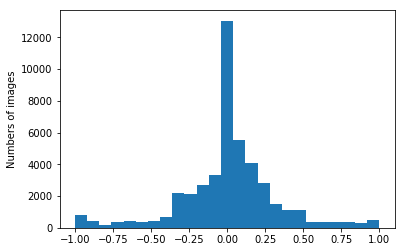

In [5]:
plt.hist(data['sin'], bins=25,range=[-1,1],align='mid')
plt.ylabel('Numbers of images')
plt.show()

In [6]:
mid_bar_start = -1+ (2/25)*12
mid_bar_end = -1+ (2/25)*13
larger_than_start = data['sin'] > mid_bar_start
smaller_than_end = data['sin']<mid_bar_end
mid_data = data[larger_than_start][smaller_than_end]
mid_data.head(2)

/Users/luyongyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,files,sin
0,0.jpg,0.0
1,1.jpg,0.0


In [7]:
mid_data = shuffle(mid_data)
num_rows = mid_data.shape[0]
drop_rows = mid_data[:num_rows -7000]

In [8]:
data = pd.concat([data,drop_rows]).drop_duplicates(keep=False)
data.head(2)

,files,sin
0,0.jpg,0.0
2,2.jpg,0.0


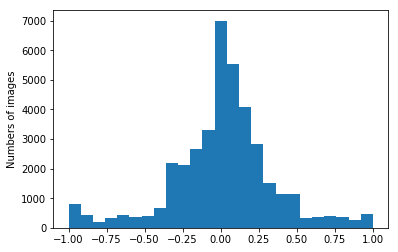

In [9]:
plt.hist(data['sin'], bins=25,range=[-1,1],align='mid')
plt.ylabel('Numbers of images')
plt.show()

**Preprocess imagess**

In [10]:
def preprocess_img(path):
    img = mpimg.imread(path)
    part = img[150:,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,(3,3),0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img
  

**Create a batch generator**

In [11]:
#shuffle Dataframe, reset indexes
data.sample(frac=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(2)

,files,sin
0,32616.jpg,-0.469934
1,15532.jpg,-0.257470


In [12]:
def split_df(df,split_test):
    df = df.sample(frac=1).reset_index(drop=True)
    total_samples = df.shape[0]

    num_train = total_samples * (1-split_test)
    num_test = total_samples* split_test

    train_df = df.loc[:num_train]
    test_df = df.loc[num_train:]

    return train_df, test_df

In [13]:
train_df, test_df = split_df(data,split_test = 0.2)
print("number of training data",train_df.shape[0])
print("number of testing data", test_df.shape[0])

number of training data 31485
number of testing data 7871


In [14]:
def batch_generator(df,batch_size):
    while True:
        batch = df.sample(n = batch_size)
        batch_paths  =  "driving_dataset/" + batch['files']
        df_sin = batch['sin'] 

        batch_imgs = np.asarray(list(map(preprocess_img, batch_paths)))
        batch_sin = np.asarray(df_sin)

        yield (batch_imgs, batch_sin)
  
  
 
  

**Create a model**

In [16]:
def create_model():
    model = Sequential()
    model.add(Conv2D(24,(5,5),padding ="valid",strides = (2,2), input_shape = (66,200,3),activation = 'elu'))
    model.add(Conv2D(36,(5,5),padding = "valid",strides = (2,2), activation = "elu"))
    model.add(Conv2D(48,(5,5),padding = "valid",strides = (2,2), activation = "elu"))
    model.add(Conv2D(64,(3,3),padding = "valid", activation = "elu"))
    model.add(Conv2D(64,(3,3),padding = "valid", activation = "elu"))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation = "elu",name = "2nd_dense"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation = "elu",name= "3rd_dense"))
    model.add(Dense(10, activation = "elu",name = "4th_dense"))
    model.add(Dense(1))
    model.compile(optimizer = Adam(),loss="mse")
    return model



In [17]:
model = create_model()
model.summary()

W0822 10:27:17.791414 4704044480 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 10:27:17.804074 4704044480 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 10:27:17.806025 4704044480 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 10:27:17.849383 4704044480 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

**Fit data into the model**

In [18]:
steps_train = train_df.shape[0]//64
print(steps_train)

491


In [19]:
history = model.fit_generator(
    batch_generator(train_df, batch_size = 64),
    steps_per_epoch = train_df.shape[0]//64,
    validation_data = batch_generator(test_df, batch_size = 64),
    validation_steps = test_df.shape[0]//64,
    verbose = 1,
    epochs = 10)

W0822 10:27:18.141556 4704044480 deprecation_wrapper.py:119] From /Users/luyongyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
491/491 [==============================] - 180s 368ms/step - loss: 0.0944 - val_loss: 0.0647
Epoch 2/10
491/491 [==============================] - 180s 366ms/step - loss: 0.0536 - val_loss: 0.0416
Epoch 3/10
491/491 [==============================] - 180s 366ms/step - loss: 0.0434 - val_loss: 0.0388
Epoch 4/10
491/491 [==============================] - 175s 356ms/step - loss: 0.0393 - val_loss: 0.0322
Epoch 5/10
491/491 [==============================] - 169s 345ms/step - loss: 0.0352 - val_loss: 0.0264
Epoch 6/10
491/491 [==============================] - 172s 351ms/step - loss: 0.0319 - val_loss: 0.0253
Epoch 7/10
491/491 [==============================] - 174s 355ms/step - loss: 0.0295 - val_loss: 0.0267
Epoch 8/10
491/491 [==============================] - 178s 363ms/step - loss: 0.0263 - val_loss: 0.0188
Epoch 9/10
491/491 [==============================] - 177s 361ms/step - loss: 0.0252 - val_loss: 0.0172
Epoch 10/10
491/491 [==============================] - 168s 342m

**Plot the result**

Text(0.5, 0, 'Epoch')

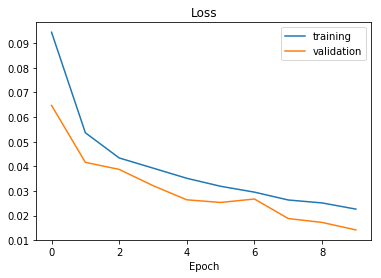

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [21]:
model.save('model.h5')